In [1]:
import numpy as np
import matplotlib.pyplot as plt

from algorithms.gam import gam
from algorithms.lv_hba import lv_hba
from algorithms.blocc import blocc
from algorithms import barrier_blo

from utils import *

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
plt.rcParams.update({'font.size': 32})
plt.rcParams['font.sans-serif']=['Times New Roman']
plt.rcParams['axes.unicode_minus']=False
cmap = plt.get_cmap("tab10")

In [22]:
epochs = 80
seeds = 10

In [23]:
hparams = {
    'lv_hba': {
        'alpha': 0.01,
        'gama1': 0.1,
        'gama2': 0.1,
        'yita': 0.001
    },
    'gam': {
        'alpha': 0.05,
        'epsilon': 0.005
    },
    'blocc': {
        'gam': 10,
        'eta': 0.01
    },
    'barrier_blo': {
        'alpha': 2,
        'beta': 0.01,
        'epsilon': 3,
        'max_iters_outer': 5,
        'max_iters_inner': 5,
        'M': 0.5,
        't': 1e-3
    }
}

# Dataset Diabetes

In [24]:
dataset_name = "diabetes"
data = load_diabetes()

n_train = 500
n_val = 150

In [25]:
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(data, 10, n_train, n_val)
x_train.shape, x_val.shape, x_test.shape

((500, 45), (150, 45), (118, 45))

In [26]:
metrics_diabetes = {}
variables_diabetes = {}

algs = ['blocc', 'barrier_blo', 'lv_hba']

for a in algs:
    metrics_diabetes[a] = []
    variables_diabetes[a] = []

for seed in range(seeds):

    print(f"Starting seed {seed+1}/{seeds}: ", end="")

    x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(data, seed, n_train, n_val)

    for alg in algs:
        print(f"{alg}", end=" ")
        if alg == 'barrier_blo':
            c0, w0, b0, xi0 = 3 * np.ones(n_train), np.ones(45), np.zeros(), np.ones(n_train)
            datasets = {
                'x_train': x_train, 'y_train': y_train, 'x_val': x_val, 
                'y_val': y_val, 'x_test': x_test, 'y_test': y_test
            }
    
            problem = barrier_blo.SVM_Problem(datasets)
            algo = barrier_blo.Barrier_BLO(problem, hparams['barrier_blo'])
            metrics_seed, c, w, b, xi, grad_norm = algo.upper_loop(c0, w0, b0, xi0, hparams['barrier_blo'])
            metrics_diabetes[alg].append(metrics_seed)
            variables_diabetes[alg].append([c, w, b, xi])
        else:
            metrics_seed, variables_seed = eval(alg)(x_train, y_train, x_val, y_val, x_test, y_test, hparams[alg], epochs, verbose=False)
            metrics_diabetes[alg].append(metrics_seed)
            variables_diabetes[alg].append(variables_seed)
    print("DONE")

Starting seed 1/10: blocc 

e:\software\Anaconda\envs\BLO\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


barrier_blo     Inner loop PGD total iter: 3, grad norm: 2.081540158176992, M: 0.5
hessian_y shape: (546, 546), jacobian shape: (500, 546), np.block([grad_w, grad_b, grad_xi]) shape: (546,)
Upper iter: 0, grad norm of hyperfunction: 221.59389863345507
Epoch [0/5]: val acc: 0.83 val loss: 1.77 test acc: 0.79 test loss: 2.00
    Inner loop PGD total iter: 1, grad norm: 1.868561217840898, M: 0.5
hessian_y shape: (546, 546), jacobian shape: (500, 546), np.block([grad_w, grad_b, grad_xi]) shape: (546,)
Upper iter: 1, grad norm of hyperfunction: 219.44856865233243
    Inner loop PGD total iter: 1, grad norm: 1.7276546649018236, M: 0.5
hessian_y shape: (546, 546), jacobian shape: (500, 546), np.block([grad_w, grad_b, grad_xi]) shape: (546,)
Upper iter: 2, grad norm of hyperfunction: 217.3117770442713
    Inner loop PGD total iter: 1, grad norm: 1.6239624287963603, M: 0.5
hessian_y shape: (546, 546), jacobian shape: (500, 546), np.block([grad_w, grad_b, grad_xi]) shape: (546,)
Upper iter: 3, g

## Evaluation

In [55]:
results_path = 'Plots_diabetes/'# f'../results/hyperparam_opt/{dataset_name}/'

In [56]:
axis_barrier_blo = []
for metrics in metrics_barrier_blo:
    temp = []
    for metric in metrics:
        if 'time_computation' in metric:
            temp.append(metric['time_computation'])
        else:
            print("Missing 'time_computation' in", metric)
            temp.append(np.nan)  # 或者使用一个默认值，例如 np.nan
    axis_barrier_blo.append(temp)
axis_barrier_blo = np.array(axis_barrier_blo)



In [57]:
metrics_lvhba = metrics_diabetes['lv_hba']
# metrics_gam = metrics_diabetes['gam']
metrics_blocc = metrics_diabetes['blocc']
metrics_barrier_blo = metrics_diabetes['barrier_blo']

axis_lvhba_all = np.array([[x['time_computation'] for x in metrics] for metrics in metrics_lvhba])
# axis_gam_all = np.array([[x['time_computation'] for x in metrics] for metrics in metrics_gam])
axis_blocc_all = np.array([[x['time_computation'] for x in metrics] for metrics in metrics_blocc])
axis_barrier_blo = np.array([[x['time_computation'] for x in metrics] for metrics in metrics_barrier_blo])



axis_lvhba = axis_lvhba_all.mean(0)
# axis_gam = axis_gam_all.mean(0)
axis_blocc = axis_blocc_all.mean(0)
axis_barrier_blo = axis_barrier_blo.mean(0)

axis_iter = np.arange(epochs)

In [58]:
train_acc_lvhba = np.array([[x['train_acc'] for x in metric] for metric in metrics_lvhba])
# train_acc_ga = np.array([[x['train_acc'] for x in metric] for metric in metrics_gam])
train_acc_blocc = np.array([[x['train_acc_F'] for x in metric] for metric in metrics_blocc])
train_barrier_blo = np.array([[x['train_acc'] for x in metric] for metric in metrics_barrier_blo])

val_acc_lvhba = np.array([[x['val_acc'] for x in metric] for metric in metrics_lvhba])
# val_acc_ga = np.array([[x['val_acc'] for x in metric] for metric in metrics_gam])
val_acc_blocc = np.array([[x['val_acc_F'] for x in metric] for metric in metrics_blocc])
val_acc_barrier_blo = np.array([[x['val_acc'] for x in metric] for metric in metrics_barrier_blo])

test_acc_lvhba = np.array([[x['test_acc'] for x in metric] for metric in metrics_lvhba])
# test_acc_ga = np.array([[x['test_acc'] for x in metric] for metric in metrics_gam])
test_acc_blocc = np.array([[x['test_acc_F'] for x in metric] for metric in metrics_blocc])
test_acc_barrier_blo = np.array([[x['test_acc'] for x in metric] for metric in metrics_barrier_blo])

In [59]:
val_loss_lvhba = np.array([[x['val_loss'] for x in metric] for metric in metrics_lvhba])[:,0:]
# val_loss_ga = np.array([[x['val_loss'] for x in metric] for metric in metrics_gam])[:,0:]
val_loss_blocc = np.array([[x['val_loss_F'] for x in metric] for metric in metrics_blocc])[:,0:]
val_loss_barrier_blo = np.array([[x['val_loss'] for x in metric] for metric in metrics_barrier_blo])[:,0:]


test_loss_lvhba = np.array([[x['test_loss'] for x in metric] for metric in metrics_lvhba])[:,0:]
# test_loss_ga = np.array([[x['test_loss'] for x in metric] for metric in metrics_gam])[:,0:]
test_loss_blocc = np.array([[x['test_loss_F'] for x in metric] for metric in metrics_blocc])[:,0:]
test_loss_barrier_blo = np.array([[x['test_loss'] for x in metric] for metric in metrics_barrier_blo])[:,0:]

lower_loss_lvhba = np.array([[x['loss_lower'] for x in metric] for metric in metrics_lvhba])[:,1:]
# lower_loss_ga = np.array([[x['loss_lower'] for x in metric] for metric in metrics_gam])[:,1:]
lower_loss_blocc = np.array([[x['loss_lower'] for x in metric] for metric in metrics_blocc])[:,1:]
# lower_loss_barrier_blo = np.array([[x['loss_lower'] for x in metric] for metric in metrics_barrier_blo])[:,1:]

# constraint_violation_lvhba = np.array([[x['constraint_violation'] for x in metric] for metric in metrics_lvhba])[:,1:]
# constraint_violation_blocc = np.array([[x['constraint_violation'] for x in metric] for metric in metrics_blocc])[:,1:]

### Measuring Convergence Time
When `(UpperLoss_{t+1}-UpperLoss_t)^2` is smaller than `eps = 1e-5`. We say convergence happen.

In [60]:
print("-------------- Accuracy -------------")
print('blocc: {:0.3f} ({:0.3f})'.format(test_acc_blocc[:,-1].mean(),test_acc_blocc[:,-1].std()))
print('lvhba: {:0.3f} ({:0.3f})'.format(test_acc_lvhba[:,-1].mean(),test_acc_lvhba[:,-1].std()))
# print('gam: {:0.3f} ({:0.3f})'.format(test_acc_ga[:,-1].mean(),test_acc_ga[:,-1].std()))
print('barrier_blo: {:0.3f} ({:0.3f})'.format(test_acc_barrier_blo[:,-1].mean(),test_acc_barrier_blo[:,-1].std()))

-------------- Accuracy -------------
blocc: 0.750 (0.032)
lvhba: 0.755 (0.042)
barrier_blo: 0.753 (0.037)


In [61]:
eps = 1e-5

diff_val_loss_blocc = np.diff(val_loss_blocc,axis=1)**2
diff_val_loss_blocc[diff_val_loss_blocc<eps]=0
converged_id_blocc = np.argmin(diff_val_loss_blocc,axis = 1)

diff_val_loss_lvhba = np.diff(val_loss_lvhba,axis=1)**2
diff_val_loss_lvhba[diff_val_loss_lvhba<eps]=0
converged_id_lvhba = np.argmin(diff_val_loss_lvhba,axis = 1)

# diff_val_loss_ga = np.diff(val_loss_ga,axis=1)**2
# diff_val_loss_ga[diff_val_loss_ga<eps]=0
# converged_id_ga = np.argmin(diff_val_loss_ga,axis = 1)

diff_val_loss_barrier_blo = np.diff(val_loss_barrier_blo,axis=1)**2
diff_val_loss_barrier_blo[diff_val_loss_barrier_blo<eps]=0
converged_id_barrier_blo = np.argmin(diff_val_loss_barrier_blo,axis = 1)

time_blocc = []
time_lvhba = []
time_ga = []
time_barrier_blo=[]
for i in range(seeds):
    time_blocc.append(axis_blocc_all[i,converged_id_blocc[i]+1])
    time_lvhba.append(axis_lvhba_all[i,converged_id_lvhba[i]+1])
    # time_ga.append(axis_gam_all[i,converged_id_ga[i]+1])
    time_barrier_blo.append(axis_barrier_blo[i,converged_id_barrier_blo[i]+1])
time_blocc = np.array(time_blocc)
time_lvhba = np.array(time_lvhba)
# time_ga = np.array(time_ga)
time_barrier_blo = np.array(time_barrier_blo)
print("-------------- Running Time -------------")
print('blocc: {:0.3f} ({:0.3f})'.format(time_blocc.mean(),time_blocc.std()))
print('lvhba: {:0.3f} ({:0.3f})'.format(time_lvhba.mean(),time_lvhba.std()))
# print('gam: {:0.3f} ({:0.3f})'.format(time_ga.mean(),time_ga.std()))
print('barrier_blo: {:0.3f} ({:0.3f})'.format(time_barrier_blo.mean(),time_barrier_blo.std()))


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

### Plots

ValueError: where size (1) does not match x size (6)

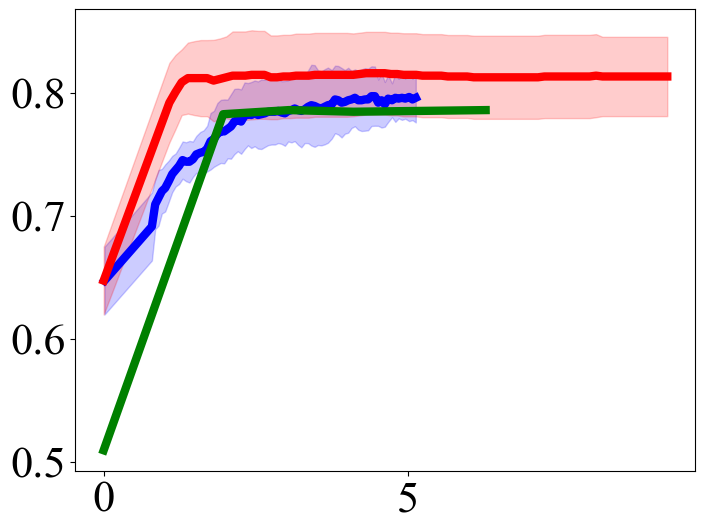

In [74]:
plt.figure(figsize=(8,6))

plt.plot(axis_lvhba,val_acc_lvhba.mean(0),'-', color = 'b',linewidth = 6, label="LV-HBA")
plt.fill_between(axis_lvhba,val_acc_lvhba.mean(0)-val_acc_lvhba.std(0),val_acc_lvhba.mean(0)+val_acc_lvhba.std(0), color = 'b',alpha=0.2)

# plt.plot(axis_gam,val_acc_ga.mean(0),'--', color = cmap(2), linewidth = 4, label="GAM")
# plt.fill_between(axis_gam,val_acc_ga.mean(0)-val_acc_ga.std(0),val_acc_ga.mean(0)+val_acc_ga.std(0), color = cmap(2), alpha=0.2)

plt.plot(axis_blocc,val_acc_blocc.mean(0),'-',color='r',linewidth = 6, label="BLOCC")
plt.fill_between(axis_blocc,val_acc_blocc.mean(0)-val_acc_blocc.std(0),val_acc_blocc.mean(0)+val_acc_blocc.std(0),color='r', alpha=0.2)

plt.plot(axis_barrier_blo,val_acc_barrier_blo.mean(0),'-',color='g', linewidth = 6, label="barrier_blo")
plt.fill_between(axis_barrier_blo,val_acc_barrier_blo.mean(0)-val_acc_barrier_blo.std(0),val_acc_barrier_blo.mean(0)+val_acc_barrier_blo.std(0),'g', alpha=0.2)

# Get the handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Reorder the handles and labels as needed
order = [2,0,1]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]

# Create the legend with the new order
plt.legend(ordered_handles, ordered_labels)
              
plt.title('Validation Accuracy')
plt.xlabel('Running time /s')
plt.ylabel("Accuracy")
plt.xlim([0,axis_lvhba.max()])
plt.savefig(results_path + 'val_accuracy_running_time.pdf', bbox_inches="tight")

In [71]:
plt.figure(figsize=(8,6))

iter_axis = np.arange(val_acc_ga.shape[1])


plt.plot(axis_iter,val_acc_lvhba.mean(0),'-',color = cmap(0), linewidth = 4,  label="LV-HBA")
plt.fill_between(axis_iter,val_acc_lvhba.mean(0)-val_acc_lvhba.std(0),val_acc_lvhba.mean(0)+val_acc_lvhba.std(0),color = cmap(0), alpha=0.2)

# plt.plot(axis_iter,val_acc_ga.mean(0),'--',color = cmap(2),  linewidth = 4, label="GAM")
# plt.fill_between(axis_iter,val_acc_ga.mean(0)-val_acc_ga.std(0),val_acc_ga.mean(0)+val_acc_ga.std(0),color = cmap(2), alpha=0.2)

plt.plot(axis_iter,val_acc_blocc.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")
plt.fill_between(axis_iter,val_acc_blocc.mean(0)-val_acc_blocc.std(0),val_acc_blocc.mean(0)+val_acc_blocc.std(0),color = 'r',alpha=0.2)

plt.legend(ordered_handles, ordered_labels)

plt.title('Validation Accuracy')
plt.xlabel('Iteration Count')
plt.ylabel("Accuracy")


plt.savefig(results_path + 'val_accuracy_iteration.pdf', bbox_inches="tight")

NameError: name 'val_acc_ga' is not defined

<Figure size 800x600 with 0 Axes>

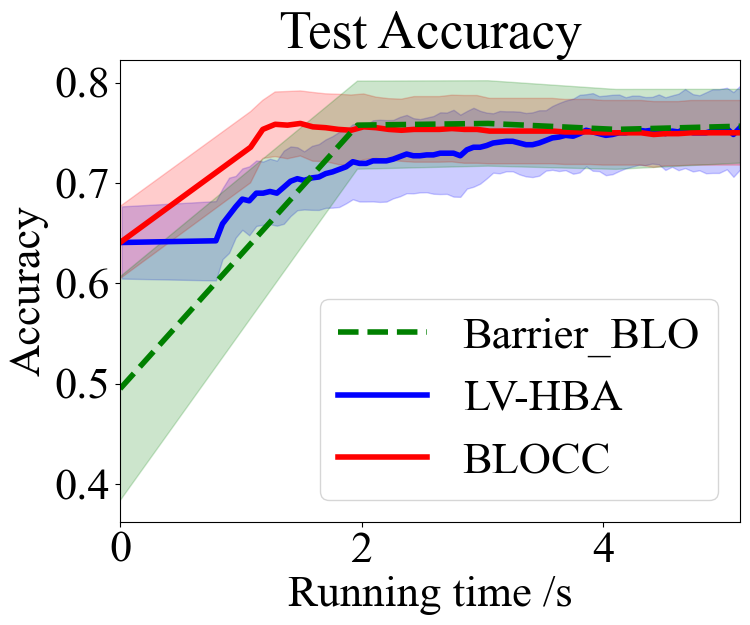

In [69]:
plt.figure(figsize=(8,6))

plt.plot(axis_lvhba,test_acc_lvhba.mean(0),'-',linewidth = 4, color = 'b',label="LV-HBA")
plt.fill_between(axis_lvhba,test_acc_lvhba.mean(0)-test_acc_lvhba.std(0),test_acc_lvhba.mean(0)+test_acc_lvhba.std(0),color = 'b',alpha=0.2)

# plt.plot(axis_gam,test_acc_ga.mean(0),'--',linewidth = 4, color = cmap(2),label="GAM")
# plt.fill_between(axis_gam,test_acc_ga.mean(0)-test_acc_ga.std(0),test_acc_ga.mean(0)+test_acc_ga.std(0),color = cmap(2),alpha=0.2)

plt.plot(axis_blocc,test_acc_blocc.mean(0),'-',linewidth = 4, color = 'r',label="BLOCC")
plt.fill_between(axis_blocc,test_acc_blocc.mean(0)-test_acc_blocc.std(0),test_acc_blocc.mean(0)+test_acc_blocc.std(0),color = 'r',alpha=0.2)

plt.plot(axis_barrier_blo,test_acc_barrier_blo.mean(0),'--',linewidth = 4, color = 'g',label="Barrier_BLO")
plt.fill_between(axis_barrier_blo,test_acc_barrier_blo.mean(0)-test_acc_barrier_blo.std(0),test_acc_barrier_blo.mean(0)+test_acc_barrier_blo.std(0),color = 'g',alpha=0.2)

# Get the handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
# Reorder the handles and labels as needed
order = [2,0,1]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
# Create the legend with the new order
plt.legend(ordered_handles, ordered_labels)

plt.title('Test Accuracy')
plt.xlabel('Running time /s')
plt.ylabel("Accuracy")

plt.xlim([0,axis_lvhba.max()])
plt.savefig(results_path + 'test_accuracy_running_time.pdf', bbox_inches="tight")

NameError: name 'test_acc_ga' is not defined

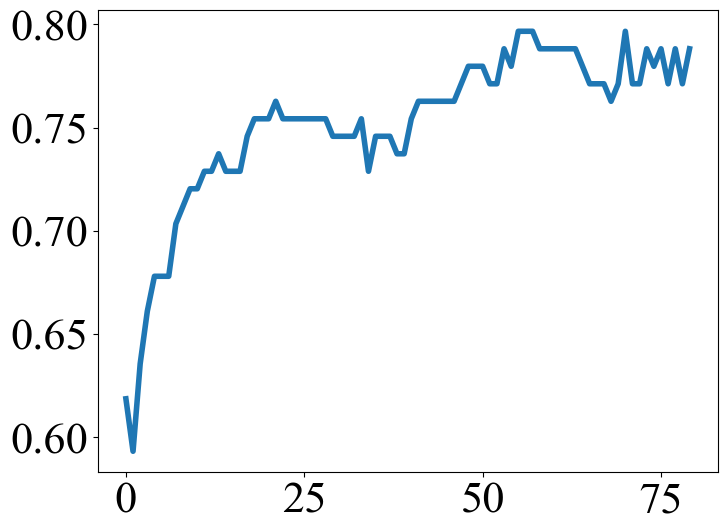

In [21]:
plt.figure(figsize=(8,6))

plt.plot(axis_iter,test_acc_lvhba.mean(0),'-',color = cmap(0),linewidth = 4, label="LV-HBA")
plt.fill_between(axis_iter,test_acc_lvhba.mean(0)-test_acc_lvhba.std(0),test_acc_lvhba.mean(0)+test_acc_lvhba.std(0),color = cmap(0),alpha=0.2)

plt.plot(axis_iter,test_acc_ga.mean(0),'--',color = cmap(2),linewidth = 4, label="GAM")
plt.fill_between(axis_iter,test_acc_ga.mean(0)-test_acc_ga.std(0),test_acc_ga.mean(0)+test_acc_ga.std(0),color = cmap(2),alpha=0.2)


plt.plot(axis_iter,test_acc_blocc.mean(0),'-',color = 'r',linewidth = 4, label="BLOCC")
plt.fill_between(axis_iter,test_acc_blocc.mean(0)-test_acc_blocc.std(0),test_acc_blocc.mean(0)+test_acc_blocc.std(0),color = 'r',alpha=0.2)


plt.legend(ordered_handles, ordered_labels)

plt.title('Test Accuracy')
plt.xlabel('Iteration Count')
plt.ylabel("Accuracy")
plt.savefig(results_path + 'test_accuracy_iteration.pdf', bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,6))


plt.plot(iter_axis,val_loss_lvhba.mean(0),'-',color = cmap(0), linewidth = 4, label="LV-HBA")
fill_dn_LV = val_loss_lvhba.mean(0)-val_loss_lvhba.std(0)
fill_up_LV = val_loss_lvhba.mean(0)+val_loss_lvhba.std(0)
plt.fill_between(iter_axis[1:],fill_dn_LV[1:],fill_up_LV[1:],color = cmap(0), alpha=0.2)

plt.plot(iter_axis,val_loss_ga.mean(0),'--',color = cmap(2), linewidth = 4, label="GAM")
fill_up_GAM = val_loss_ga.mean(0)-val_loss_ga.std(0)
fill_dn_GAM = val_loss_ga.mean(0)+val_loss_ga.std(0)
plt.fill_between(iter_axis[1:],fill_dn_GAM[1:],fill_up_GAM[1:],color = cmap(2), alpha=0.2)

plt.plot(iter_axis,val_loss_blocc.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")
fill_dn_blocc = val_loss_blocc.mean(0)-val_loss_blocc.std(0)
fill_up_blocc = val_loss_blocc.mean(0)+val_loss_blocc.std(0)
plt.fill_between(iter_axis[1:],fill_dn_blocc[1:],fill_up_blocc[1:],color = 'r', alpha=0.2)

plt.legend(ordered_handles, ordered_labels)

plt.title('Validation Loss (Upper Level)')
plt.xlabel('Iteration Count')
plt.ylabel("Loss")


plt.ylim([1.5,3.4])
plt.savefig(results_path + 'upper_obj_iteration.pdf', bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,6))


plt.plot(axis_lvhba,val_loss_lvhba.mean(0),'-',color = cmap(0), linewidth = 4, label="LV-HBA")
fill_dn_LV = val_loss_lvhba.mean(0)-val_loss_lvhba.std(0)
fill_up_LV = val_loss_lvhba.mean(0)+val_loss_lvhba.std(0)
plt.fill_between(axis_lvhba[1:],fill_dn_LV[1:],fill_up_LV[1:],color = cmap(0), alpha=0.2)

plt.plot(axis_gam,val_loss_ga.mean(0),'--',color = cmap(2), linewidth = 4, label="GAM")
fill_up_GAM = val_loss_ga.mean(0)-val_loss_ga.std(0)
fill_dn_GAM = val_loss_ga.mean(0)+val_loss_ga.std(0)
plt.fill_between(axis_gam[1:],fill_dn_GAM[1:],fill_up_GAM[1:],color = cmap(2), alpha=0.2)

plt.plot(axis_blocc,val_loss_blocc.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")
fill_dn_blocc = val_loss_blocc.mean(0)-val_loss_blocc.std(0)
fill_up_blocc = val_loss_blocc.mean(0)+val_loss_blocc.std(0)
plt.fill_between(axis_blocc[1:],fill_dn_blocc[1:],fill_up_blocc[1:],color = 'r', alpha=0.2)

plt.legend(ordered_handles, ordered_labels)
plt.title('Validation Loss (Upper Level)')
plt.xlabel('Running Time /s')
plt.ylabel("Loss")

plt.ylim([1.5,4])
plt.xlim([0,13])
plt.xlim([0,axis_lvhba.max()])
plt.savefig(results_path + 'upper_obj_time.pdf', bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,6))


plt.plot(iter_axis,test_loss_lvhba.mean(0),'-',color = cmap(0), linewidth = 4, label="LV-HBA")
fill_dn_LV = test_loss_lvhba.mean(0)-test_loss_lvhba.std(0)
fill_up_LV = test_loss_lvhba.mean(0)+test_loss_lvhba.std(0)
plt.fill_between(iter_axis[1:],fill_dn_LV[1:],fill_up_LV[1:],color = cmap(0), alpha=0.2)

plt.plot(iter_axis,test_loss_ga.mean(0),'--',color = cmap(2), linewidth = 4, label="GAM")
fill_up_GAM = test_loss_ga.mean(0)-test_loss_ga.std(0)
fill_dn_GAM = test_loss_ga.mean(0)+test_loss_ga.std(0)
plt.fill_between(iter_axis[1:],fill_dn_GAM[1:],fill_up_GAM[1:],color = cmap(2), alpha=0.2)

plt.plot(iter_axis,test_loss_blocc.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")
fill_dn_blocc = test_loss_blocc.mean(0)-test_loss_blocc.std(0)
fill_up_blocc = test_loss_blocc.mean(0)+test_loss_blocc.std(0)
plt.fill_between(iter_axis[1:],fill_dn_blocc[1:],fill_up_blocc[1:],color = 'r', alpha=0.2)
plt.legend()
plt.title('Test Loss')
plt.xlabel('Iteration Count')
plt.ylabel("Loss")

plt.ylim([1.5,3.4])
plt.savefig(results_path + 'test_obj_iteration.pdf', bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(iter_axis[1:],lower_loss_blocc.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")
# fill_dn_blocc = lower_loss_blocc.mean(0)-lower_loss_blocc.std(0)
# fill_up_blocc = lower_loss_blocc.mean(0)+lower_loss_blocc.std(0)
# plt.fill_between(iter_axis[1:],fill_dn_blocc,fill_up_blocc,alpha=0.2)
# the above didn't work as the standard deviation is too small

plt.plot(iter_axis[1:],lower_loss_lvhba.mean(0),'-',color = cmap(0), linewidth = 4, label="LV-HBA")
fill_dn_LV = lower_loss_lvhba.mean(0)-lower_loss_lvhba.std(0)
fill_up_LV = lower_loss_lvhba.mean(0)+lower_loss_lvhba.std(0)
plt.fill_between(iter_axis[1:],fill_dn_LV,fill_up_LV,color = cmap(0),alpha=0.2)

plt.plot(iter_axis[1:],lower_loss_ga.mean(0),'--', color = cmap(2),linewidth = 4, label="GAM")
fill_up_GAM = lower_loss_ga.mean(0)-lower_loss_ga.std(0)
fill_dn_GAM = lower_loss_ga.mean(0)+lower_loss_ga.std(0)
plt.fill_between(iter_axis[1:],fill_dn_GAM,fill_up_GAM,color = cmap(2),alpha=0.2)

plt.legend()
plt.title('Lower Level Objective')
plt.xlabel('Iteration Count')
plt.ylabel("Loss")

plt.savefig(results_path + 'lower_obj_iteration.pdf', bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(axis_blocc[1:],lower_loss_blocc.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")
# fill_dn_blocc = lower_loss_blocc.mean(0)-lower_loss_blocc.std(0)
# fill_up_blocc = lower_loss_blocc.mean(0)+lower_loss_blocc.std(0)
# plt.fill_between(iter_axis[1:],fill_dn_blocc,fill_up_blocc,alpha=0.2)
# the above didn't work as the standard deviation is too small

plt.plot(axis_lvhba[1:],lower_loss_lvhba.mean(0),'-',color = cmap(0), linewidth = 4, label="LV-HBA")
fill_dn_LV = lower_loss_lvhba.mean(0)-lower_loss_lvhba.std(0)
fill_up_LV = lower_loss_lvhba.mean(0)+lower_loss_lvhba.std(0)
plt.fill_between(axis_lvhba[1:],fill_dn_LV,fill_up_LV,color = cmap(0),alpha=0.2)

plt.plot(axis_gam[1:],lower_loss_ga.mean(0),'--', color = cmap(2),linewidth = 4, label="GAM")
fill_up_GAM = lower_loss_ga.mean(0)-lower_loss_ga.std(0)
fill_dn_GAM = lower_loss_ga.mean(0)+lower_loss_ga.std(0)
plt.fill_between(axis_gam[1:],fill_dn_GAM,fill_up_GAM,color = cmap(2),alpha=0.2)

plt.legend()
plt.title('Lower Level Objective')
plt.xlabel('Running Time /s')
plt.ylabel("Loss")
plt.xlim([0,axis_lvhba.max()])

plt.savefig(results_path + 'lower_obj_time.pdf', bbox_inches="tight")

# Dataset Fourclass

In [ ]:
dataset_name = "fourclass"
data = load_fourclass()

n_train = 500
n_val = 150

In [ ]:
metrics_fourclass = {}
variables_fourclass = {}

algs = ['blocc', 'lv_hba', 'gam']

for a in algs:
    metrics_fourclass[a] = []
    variables_fourclass[a] = []

for seed in range(seeds):

    print(f"Starting seed {seed+1}/{seeds}: ", end="")

    x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(data, seed, n_train, n_val)

    for alg in algs:
        print(f"{alg}", end=" ")

        metrics_seed, variables_seed = eval(alg)(x_train, y_train, x_val, y_val, x_test, y_test, hparams[alg], epochs, verbose=False)
        metrics_fourclass[alg].append(metrics_seed)
        variables_fourclass[alg].append(variables_seed)
    print("DONE")

## Evaluation

In [ ]:
results_path = 'Plots_fourclass/'#f'../results/hyperparam_opt/{dataset_name}/'

In [ ]:
metrics_lvhba = metrics_fourclass['lv_hba']
metrics_gam = metrics_fourclass['gam']
metrics_blocc = metrics_fourclass['blocc']


axis_lvhba_all = np.array([[x['time_computation'] for x in metrics] for metrics in metrics_lvhba])
axis_gam_all = np.array([[x['time_computation'] for x in metrics] for metrics in metrics_gam])
axis_blocc_all = np.array([[x['time_computation'] for x in metrics] for metrics in metrics_blocc])

axis_lvhba = axis_lvhba_all.mean(0)
axis_gam = axis_gam_all.mean(0)
axis_blocc = axis_blocc_all.mean(0)

axis_iter = np.arange(epochs)

In [ ]:
train_acc_lvhba = np.array([[x['train_acc'] for x in metrics] for metrics in metrics_lvhba])
train_acc_ga = np.array([[x['train_acc'] for x in metrics] for metrics in metrics_gam])
train_acc_blocc = np.array([[x['train_acc_F'] for x in metrics] for metrics in metrics_blocc])

val_acc_lvhba = np.array([[x['val_acc'] for x in metrics] for metrics in metrics_lvhba])
val_acc_ga = np.array([[x['val_acc'] for x in metrics] for metrics in metrics_gam])
val_acc_blocc = np.array([[x['val_acc_F'] for x in metrics] for metrics in metrics_blocc])

test_acc_lvhba = np.array([[x['test_acc'] for x in metrics] for metrics in metrics_lvhba])
test_acc_ga = np.array([[x['test_acc'] for x in metrics] for metrics in metrics_gam])
test_acc_blocc = np.array([[x['test_acc_F'] for x in metrics] for metrics in metrics_blocc])

In [ ]:
val_loss_lvhba = np.array([[x['val_loss'] for x in metrics] for metrics in metrics_lvhba])[:,0:]
val_loss_ga = np.array([[x['val_loss'] for x in metrics] for metrics in metrics_gam])[:,0:]
val_loss_blocc = np.array([[x['val_loss_F'] for x in metrics] for metrics in metrics_blocc])[:,0:]

test_loss_lvhba = np.array([[x['test_loss'] for x in metrics] for metrics in metrics_lvhba])[:,0:]
test_loss_ga = np.array([[x['test_loss'] for x in metrics] for metrics in metrics_gam])[:,0:]
test_loss_blocc = np.array([[x['test_loss_F'] for x in metrics] for metrics in metrics_blocc])[:,0:]

lower_loss_lvhba = np.array([[x['loss_lower'] for x in metrics] for metrics in metrics_lvhba])[:,1:]
lower_loss_ga = np.array([[x['loss_lower'] for x in metrics] for metrics in metrics_gam])[:,1:]
lower_loss_blocc = np.array([[x['loss_lower'] for x in metrics] for metrics in metrics_blocc])[:,1:]


### Measuring Convergence Time
When `(UpperLoss_{t+1}-UpperLoss_t)^2` is smaller than `eps = 1e-10`. We say convergence happen.

In [ ]:
print("-------------- Accuracy -------------")
print('blocc: {:0.3f} ({:0.3f})'.format(test_acc_blocc[:,-1].mean(),test_acc_blocc[:,-1].std()))
print('lvhba: {:0.3f} ({:0.3f})'.format(test_acc_lvhba[:,-1].mean(),test_acc_lvhba[:,-1].std()))
print('gam: {:0.3f} ({:0.3f})'.format(test_acc_ga[:,-1].mean(),test_acc_ga[:,-1].std()))

In [ ]:
eps = 1e-5

diff_val_loss_blocc = np.diff(val_loss_blocc,axis=1)**2
diff_val_loss_blocc[diff_val_loss_blocc<eps]=0
converged_id_blocc = np.argmin(diff_val_loss_blocc,axis = 1)

diff_val_loss_lvhba = np.diff(val_loss_lvhba,axis=1)**2
diff_val_loss_lvhba[diff_val_loss_lvhba<eps]=0
converged_id_lvhba = np.argmin(diff_val_loss_lvhba,axis = 1)

diff_val_loss_ga = np.diff(val_loss_ga,axis=1)**2
diff_val_loss_ga[diff_val_loss_ga<eps]=0
converged_id_ga = np.argmin(diff_val_loss_ga,axis = 1)

time_blocc = []
time_lvhba = []
time_ga = []
for i in range(seeds):
    time_blocc.append(axis_blocc_all[i,converged_id_blocc[i]+1])
    time_lvhba.append(axis_lvhba_all[i,converged_id_lvhba[i]+1])
    time_ga.append(axis_gam_all[i,converged_id_ga[i]+1])

time_blocc = np.array(time_blocc)
time_lvhba = np.array(time_lvhba)
time_ga = np.array(time_ga)
print("-------------- Running Time -------------")
print('blocc: {:0.3f} ({:0.3f})'.format(time_blocc.mean(),time_blocc.std()))
print('lvhba: {:0.3f} ({:0.3f})'.format(time_lvhba.mean(),time_lvhba.std()))
print('gam: {:0.3f} ({:0.3f})'.format(time_ga.mean(),time_ga.std()))

### Plots

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(axis_lvhba,val_acc_lvhba.mean(0),'-', color = cmap(0),linewidth = 4, label="LV-HBA")
plt.fill_between(axis_lvhba,val_acc_lvhba.mean(0)-val_acc_lvhba.std(0),val_acc_lvhba.mean(0)+val_acc_lvhba.std(0), color = cmap(0),alpha=0.2)

plt.plot(axis_gam,val_acc_ga.mean(0),'--', color = cmap(2), linewidth = 4, label="GAM")
plt.fill_between(axis_gam,val_acc_ga.mean(0)-val_acc_ga.std(0),val_acc_ga.mean(0)+val_acc_ga.std(0), color = cmap(2), alpha=0.2)

plt.plot(axis_blocc,val_acc_blocc.mean(0),'-',color='r',linewidth = 4, label="BLOCC")
plt.fill_between(axis_blocc,val_acc_blocc.mean(0)-val_acc_blocc.std(0),val_acc_blocc.mean(0)+val_acc_blocc.std(0),color='r', alpha=0.2)

# Get the handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Reorder the handles and labels as needed
order = [2,0,1]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]

# Create the legend with the new order
plt.legend(ordered_handles, ordered_labels)
              
plt.title('Validation Accuracy')
plt.xlabel('Running time /s')
plt.ylabel("Accuracy")
plt.xlim([0,axis_lvhba.max()])
plt.savefig(results_path + 'val_accuracy_running_time.pdf', bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,6))

iter_axis = np.arange(val_acc_ga.shape[1])


plt.plot(axis_iter,val_acc_lvhba.mean(0),'-',color = cmap(0), linewidth = 4,  label="LV-HBA")
plt.fill_between(axis_iter,val_acc_lvhba.mean(0)-val_acc_lvhba.std(0),val_acc_lvhba.mean(0)+val_acc_lvhba.std(0),color = cmap(0), alpha=0.2)

plt.plot(axis_iter,val_acc_ga.mean(0),'--',color = cmap(2),  linewidth = 4, label="GAM")
plt.fill_between(axis_iter,val_acc_ga.mean(0)-val_acc_ga.std(0),val_acc_ga.mean(0)+val_acc_ga.std(0),color = cmap(2), alpha=0.2)

plt.plot(axis_iter,val_acc_blocc.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")
plt.fill_between(axis_iter,val_acc_blocc.mean(0)-val_acc_blocc.std(0),val_acc_blocc.mean(0)+val_acc_blocc.std(0),color = 'r',alpha=0.2)

plt.legend(ordered_handles, ordered_labels)

plt.title('Validation Accuracy')
plt.xlabel('Iteration Count')
plt.ylabel("Accuracy")


plt.savefig(results_path + 'val_accuracy_iteration.pdf', bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(axis_lvhba,test_acc_lvhba.mean(0),'-',linewidth = 4, color = cmap(0),label="LV-HBA")
plt.fill_between(axis_lvhba,test_acc_lvhba.mean(0)-test_acc_lvhba.std(0),test_acc_lvhba.mean(0)+test_acc_lvhba.std(0),color = cmap(0),alpha=0.2)

plt.plot(axis_gam,test_acc_ga.mean(0),'--',linewidth = 4, color = cmap(2),label="GAM")
plt.fill_between(axis_gam,test_acc_ga.mean(0)-test_acc_ga.std(0),test_acc_ga.mean(0)+test_acc_ga.std(0),color = cmap(2),alpha=0.2)

plt.plot(axis_blocc,test_acc_blocc.mean(0),'-',linewidth = 4, color = 'r',label="BLOCC")
plt.fill_between(axis_blocc,test_acc_blocc.mean(0)-test_acc_blocc.std(0),test_acc_blocc.mean(0)+test_acc_blocc.std(0),color = 'r',alpha=0.2)

# Get the handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
# Reorder the handles and labels as needed
order = [2,0,1]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
# Create the legend with the new order
plt.legend(ordered_handles, ordered_labels)

plt.title('Test Accuracy')
plt.xlabel('Running time /s')
plt.ylabel("Accuracy")

plt.xlim([0,axis_lvhba.max()])
plt.savefig(results_path + 'test_accuracy_running_time.pdf', bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(axis_iter,test_acc_lvhba.mean(0),'-',color = cmap(0),linewidth = 4, label="LV-HBA")
plt.fill_between(axis_iter,test_acc_lvhba.mean(0)-test_acc_lvhba.std(0),test_acc_lvhba.mean(0)+test_acc_lvhba.std(0),color = cmap(0),alpha=0.2)

plt.plot(axis_iter,test_acc_ga.mean(0),'--',color = cmap(2),linewidth = 4, label="GAM")
plt.fill_between(axis_iter,test_acc_ga.mean(0)-test_acc_ga.std(0),test_acc_ga.mean(0)+test_acc_ga.std(0),color = cmap(2),alpha=0.2)


plt.plot(axis_iter,test_acc_blocc.mean(0),'-',color = 'r',linewidth = 4, label="BLOCC")
plt.fill_between(axis_iter,test_acc_blocc.mean(0)-test_acc_blocc.std(0),test_acc_blocc.mean(0)+test_acc_blocc.std(0),color = 'r',alpha=0.2)


plt.legend(ordered_handles, ordered_labels)

plt.title('Test Accuracy')
plt.xlabel('Iteration Count')
plt.ylabel("Accuracy")
plt.savefig(results_path + 'test_accuracy_iteration.pdf', bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,6))


plt.plot(iter_axis,val_loss_lvhba.mean(0),'-',color = cmap(0), linewidth = 4, label="LV-HBA")
fill_dn_LV = val_loss_lvhba.mean(0)-val_loss_lvhba.std(0)
fill_up_LV = val_loss_lvhba.mean(0)+val_loss_lvhba.std(0)
plt.fill_between(iter_axis[1:],fill_dn_LV[1:],fill_up_LV[1:],color = cmap(0), alpha=0.2)

plt.plot(iter_axis,val_loss_ga.mean(0),'--',color = cmap(2), linewidth = 4, label="GAM")
fill_up_GAM = val_loss_ga.mean(0)-val_loss_ga.std(0)
fill_dn_GAM = val_loss_ga.mean(0)+val_loss_ga.std(0)
plt.fill_between(iter_axis[1:],fill_dn_GAM[1:],fill_up_GAM[1:],color = cmap(2), alpha=0.2)

plt.plot(iter_axis,val_loss_blocc.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")
fill_dn_blocc = val_loss_blocc.mean(0)-val_loss_blocc.std(0)
fill_up_blocc = val_loss_blocc.mean(0)+val_loss_blocc.std(0)
plt.fill_between(iter_axis[1:],fill_dn_blocc[1:],fill_up_blocc[1:],color = 'r', alpha=0.2)

plt.legend(ordered_handles, ordered_labels)

plt.title('Validation Loss / Upper Level Objective')
plt.xlabel('Iteration Count')
plt.ylabel("Loss")


plt.ylim([1.5,3.4])
plt.savefig(results_path + 'upper_obj_iteration.pdf', bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,6))


plt.plot(axis_lvhba,val_loss_lvhba.mean(0),'-',color = cmap(0), linewidth = 4, label="LV-HBA")
fill_dn_LV = val_loss_lvhba.mean(0)-val_loss_lvhba.std(0)
fill_up_LV = val_loss_lvhba.mean(0)+val_loss_lvhba.std(0)
plt.fill_between(axis_lvhba[1:],fill_dn_LV[1:],fill_up_LV[1:],color = cmap(0), alpha=0.2)

plt.plot(axis_gam,val_loss_ga.mean(0),'--',color = cmap(2), linewidth = 4, label="GAM")
fill_up_GAM = val_loss_ga.mean(0)-val_loss_ga.std(0)
fill_dn_GAM = val_loss_ga.mean(0)+val_loss_ga.std(0)
plt.fill_between(axis_gam[1:],fill_dn_GAM[1:],fill_up_GAM[1:],color = cmap(2), alpha=0.2)

plt.plot(axis_blocc,val_loss_blocc.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")
fill_dn_blocc = val_loss_blocc.mean(0)-val_loss_blocc.std(0)
fill_up_blocc = val_loss_blocc.mean(0)+val_loss_blocc.std(0)
plt.fill_between(axis_blocc[1:],fill_dn_blocc[1:],fill_up_blocc[1:],color = 'r', alpha=0.2)

plt.legend(ordered_handles, ordered_labels)
plt.title('Validation Loss (Upper Level)')
plt.xlabel('Running Time /s')
plt.ylabel("Loss")

plt.ylim([1.5,4])
plt.xlim([0,13])
plt.xlim([0,axis_lvhba.max()])
plt.savefig(results_path + 'upper_obj_time.pdf', bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,6))

fill_dn_blocc = test_loss_blocc.mean(0)-test_loss_blocc.std(0)
fill_up_blocc = test_loss_blocc.mean(0)+test_loss_blocc.std(0)
plt.fill_between(iter_axis[1:],fill_dn_blocc[1:],fill_up_blocc[1:],color = 'r', alpha=0.2)

fill_dn_LV = test_loss_lvhba.mean(0)-test_loss_lvhba.std(0)
fill_up_LV = test_loss_lvhba.mean(0)+test_loss_lvhba.std(0)
plt.fill_between(iter_axis[1:],fill_dn_LV[1:],fill_up_LV[1:],color = cmap(0), alpha=0.2)

fill_up_GAM = test_loss_ga.mean(0)-test_loss_ga.std(0)
fill_dn_GAM = test_loss_ga.mean(0)+test_loss_ga.std(0)
plt.fill_between(iter_axis[1:],fill_dn_GAM[1:],fill_up_GAM[1:],color = cmap(2), alpha=0.2)

plt.plot(iter_axis,test_loss_lvhba.mean(0),'-',color = cmap(0), linewidth = 4, label="LV-HBA")

plt.plot(iter_axis,test_loss_ga.mean(0),'--',color = cmap(2), linewidth = 4, label="GAM")

plt.plot(iter_axis,test_loss_blocc.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")


plt.legend(ordered_handles, ordered_labels)
plt.title('Test Loss')
plt.xlabel('Iteration Count')
plt.ylabel("Loss")

plt.ylim([1.5,3.4])
plt.savefig(results_path + 'test_obj_iteration.pdf', bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(iter_axis[1:],lower_loss_blocc.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")
# fill_dn_blocc = lower_loss_blocc.mean(0)-lower_loss_blocc.std(0)
# fill_up_blocc = lower_loss_blocc.mean(0)+lower_loss_blocc.std(0)
# plt.fill_between(iter_axis[1:],fill_dn_blocc,fill_up_blocc,alpha=0.2)
# the above didn't work as the standard deviation is too small

plt.plot(iter_axis[1:],lower_loss_lvhba.mean(0),'-',color = cmap(0), linewidth = 4, label="LV-HBA")
fill_dn_LV = lower_loss_lvhba.mean(0)-lower_loss_lvhba.std(0)
fill_up_LV = lower_loss_lvhba.mean(0)+lower_loss_lvhba.std(0)
plt.fill_between(iter_axis[1:],fill_dn_LV,fill_up_LV,color = cmap(0),alpha=0.2)

plt.plot(iter_axis[1:],lower_loss_ga.mean(0),'--', color = cmap(2),linewidth = 4, label="GAM")
fill_up_GAM = lower_loss_ga.mean(0)-lower_loss_ga.std(0)
fill_dn_GAM = lower_loss_ga.mean(0)+lower_loss_ga.std(0)
plt.fill_between(iter_axis[1:],fill_dn_GAM,fill_up_GAM,color = cmap(2),alpha=0.2)

plt.legend()
plt.title('Lower Loss')
plt.xlabel('Iteration Count')
plt.ylabel("Loss")

plt.savefig(results_path + 'lower_obj_iteration.pdf', bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(axis_blocc[1:],lower_loss_blocc.mean(0),'-',color = 'r', linewidth = 4, label="BLOCC")
# fill_dn_blocc = lower_loss_blocc.mean(0)-lower_loss_blocc.std(0)
# fill_up_blocc = lower_loss_blocc.mean(0)+lower_loss_blocc.std(0)
# plt.fill_between(iter_axis[1:],fill_dn_blocc,fill_up_blocc,alpha=0.2)
# the above didn't work as the standard deviation is too small

plt.plot(axis_lvhba[1:],lower_loss_lvhba.mean(0),'-',color = cmap(0), linewidth = 4, label="LV-HBA")
fill_dn_LV = lower_loss_lvhba.mean(0)-lower_loss_lvhba.std(0)
fill_up_LV = lower_loss_lvhba.mean(0)+lower_loss_lvhba.std(0)
plt.fill_between(axis_lvhba[1:],fill_dn_LV,fill_up_LV,color = cmap(0),alpha=0.2)

plt.plot(axis_gam[1:],lower_loss_ga.mean(0),'--', color = cmap(2),linewidth = 4, label="GAM")
fill_up_GAM = lower_loss_ga.mean(0)-lower_loss_ga.std(0)
fill_dn_GAM = lower_loss_ga.mean(0)+lower_loss_ga.std(0)
plt.fill_between(axis_gam[1:],fill_dn_GAM,fill_up_GAM,color = cmap(2),alpha=0.2)

plt.legend()
plt.title('Lower Level Objective')
plt.xlabel('Running Time /s')
plt.ylabel("Loss")
plt.xlim([0,axis_lvhba.max()])

plt.savefig(results_path + 'lower_obj_time.pdf', bbox_inches="tight")